In [29]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple, List, Callable

import os
import cv2

In [30]:
#from NodeClass import Node

In [31]:
files=[]
for root, dirs, in_files in os.walk("Sample"):
    for f in in_files:
        files.append(os.path.join(root, f))
gray_image0 = cv2.imread(files[0], cv2.IMREAD_UNCHANGED)
gray_image1 = cv2.imread(files[1], cv2.IMREAD_UNCHANGED)
gray_image2 = cv2.imread(files[2], cv2.IMREAD_UNCHANGED)
gray_image3 = cv2.imread(files[3], cv2.IMREAD_UNCHANGED)
gray_image4 = cv2.imread(files[4], cv2.IMREAD_UNCHANGED)
gray_image0.shape, gray_image1.shape, gray_image2.shape, gray_image3.shape, gray_image4.shape

((4584, 6441), (4597, 6393), (4280, 5916), (4621, 6428), (4572, 6405))

In [32]:
(thresh, binary_image0) = cv2.threshold(gray_image0, 150, 255, cv2.THRESH_BINARY)
(thresh, binary_image1) = cv2.threshold(gray_image1, 150, 255, cv2.THRESH_BINARY)
(thresh, binary_image2) = cv2.threshold(gray_image2, 150, 255, cv2.THRESH_BINARY)
(thresh, binary_image3) = cv2.threshold(gray_image3, 150, 255, cv2.THRESH_BINARY)
(thresh, binary_image4) = cv2.threshold(gray_image4, 150, 255, cv2.THRESH_BINARY)
binary_image0.shape, binary_image1.shape, binary_image2.shape, binary_image3.shape, binary_image4.shape

((4584, 6441), (4597, 6393), (4280, 5916), (4621, 6428), (4572, 6405))

In [33]:
def create_test_pattern(height=100, width=150):
    """Create a test binary image with multiple regions"""
    image = np.ones((height, width))
    
    # Add left block with two rectangles
    image[10:30, 20:50] = 0
    image[40:60, 15:45] = 0
    
    # Add right block with a cross pattern
    image[15:45, 90:100] = 0  # Vertical bar
    image[25:35, 80:110] = 0  # Horizontal bar
    
    # Add small noise-like patterns
    image[70:75, 30:35] = 0
    image[72:77, 33:38] = 0
    image[68:73, 35:40] = 0
    
    # Add bottom right pattern
    image[65:85, 100:120] = 0
    
    # Add some random noise (very sparse)
    rng   = np.random.default_rng(42)
    noise = rng.random(image.shape) > 0.99
    image = 255*np.logical_xor(image, noise).astype(float)
    
    return image

In [34]:
def sum_ratio_criterion(sums: np.ndarray, split_pos: int) -> float:
    """Compute ratio criterion based on sum of pixel values"""
    left_sum  = np.sum(sums[:split_pos])
    right_sum = np.sum(sums[split_pos:])
    return max(left_sum, right_sum) / (min(left_sum, right_sum) + 1e-10)

def black_pixels_ratio_criterion(sums: np.ndarray, split_pos: int, threshold: float = 0.5) -> float:
    """Compute ratio criterion based on proportion of black pixels"""
    # Convert sums to binary (assuming values above threshold are black)
    binary_sums = sums > threshold * np.max(sums)
    
    left_count  = np.sum(binary_sums[:split_pos])
    right_count = np.sum(binary_sums[split_pos:])
    
    # Normalize by length to get proportions
    left_prop = left_count / len(binary_sums[:split_pos]) if split_pos > 0 else 0
    right_prop = right_count / len(binary_sums[split_pos:]) if split_pos < len(binary_sums) else 0
    
    return max(left_prop, right_prop) / (min(left_prop, right_prop) + 1e-10)


In [35]:
@dataclass
class Node:
    """
    Tree node representing an image region and its split
    Args:
       image: A binary image
       bbox: Bounding box in original image coordinates
    """
    image: np.ndarray
    bbox:  Tuple[slice, slice]  # Bounding box in original image coordinates
    split_pos: int = -1
    direction: Optional[str] = None
    ratio: float = 0
    left:  Optional['Node'] = None
    right: Optional['Node'] = None
    
    def __eq__(self, other):
        if not isinstance(other, Node):
            return False
        return (self.bbox == other.bbox and 
                self.split_pos == other.split_pos and 
                self.direction == other.direction)
    
    def __src__(self, other):
        return(str(bbox[0]),",",str(bbox[1]))
              
    def __hash__(self):
        return hash((self.bbox, self.split_pos, self.direction))
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None

In [40]:
class ImageSplitter:
    def __init__(self, image: np.ndarray,
                 max_splits: int = 5,
                 margin: int = 5,
                 bandwidth: int = 50,
                 min_ratio: float = 2.0,
                 overall_threshold: float = 0.1,
                 criteria: Callable = black_pixels_ratio_criterion):
        """Initialize the splitter with an image and parameters"""
        self.image      = image
        self.max_splits = max_splits
        self.margin     = margin
        self.bandwidth  = bandwidth
        self.min_ratio  = min_ratio
        self.overall_threshold = overall_threshold
        self.criteria   = criteria
        self.root_node  = None
        self.leaf_nodes = []
    
    def _try_split(self, means) -> Tuple[int, float]:
        if np.max(means) < self.overall_threshold: return -1, 0
        n = len(means)
        if n-2*self.margin <= 0: return -1, 0

        # Find the position with the maximum sum of white pixels within the bandwidth
        split_pos = self.margin
        ratio     = 0
        for i in range(self.margin, n - 2*self.margin):
            current_sum = np.sum(means[(i-self.bandwidth//2):(i + self.bandwidth//2)])
            if current_sum > ratio:
                ratio     = current_sum
                split_pos = i
                
        return (split_pos, ratio) if ratio >= self.min_ratio else (-1, ratio)
    
    def _find_best_split(self, image: np.ndarray, option = "both") -> Tuple[int, Optional[str], float]:
        """Find the best split position and direction"""
        if option == "both":
            v_split_pos, v_ratio = self._try_split(np.mean(image, axis=0).flatten())
            h_split_pos, h_ratio = self._try_split(np.mean(image, axis=1).flatten())
        elif option == "vertical":
            v_split_pos, v_ratio = self._try_split(np.mean(image, axis=0).flatten())
            h_split_pos, h_ratio = (-1, 0)
        else:
            h_split_pos, h_ratio = self._try_split(np.mean(image, axis=1).flatten())
            v_split_pos, v_ratio = (-1, 0)

        if v_ratio > h_ratio and v_split_pos != -1:
            return v_split_pos, 'vertical', v_ratio
        elif h_split_pos != -1:
            return h_split_pos, 'horizontal', h_ratio
        else:
            return -1, None, min(v_ratio, h_ratio)

    def _count_splits(self, node: Optional[Node]) -> int:
        """Count the number of splits in the tree"""
        if node is None or node.is_leaf:
            return 0
        return 1 + self._count_splits(node.left) + self._count_splits(node.right)

    def _count_regions(self, node: Optional[Node]) -> int:
        """Count the number of regions (leaf nodes)"""
        if node is None:
            return 0
        if node.is_leaf:
            return 1
        return self._count_regions(node.left) + self._count_regions(node.right)

    def split(self) -> Node:
        """Perform the iterative splitting of the image"""
        # Create root node and initialize leaf_nodes array -> the root at the beginning
        height, width   = self.image.shape
        self.root_node  = Node(image=self.image, bbox=(slice(0, height), slice(0, width)) )
        self.leaf_nodes = [self.root_node]
        
        for it in range(self.max_splits):
            best_node       = None
            best_ratio      = self.min_ratio
            best_split_info = None
            
            print("Next step")
            # Find the leaf node with the best split ratio
            for node in self.leaf_nodes:
                option = "vertical" if it < 3 else "both"
                split_pos, direction, ratio = self._find_best_split(node.image, option)
                print(node.bbox, split_pos, direction, ratio)
                if split_pos != -1 and ratio > best_ratio:
                    best_node       = node
                    best_ratio      = ratio
                    best_split_info = (split_pos, direction)
            
            if best_node is None:
                break
                
            # Apply the best split
            split_pos, direction = best_split_info
            best_node.split_pos  = split_pos
            best_node.direction  = direction
            best_node.ratio      = best_ratio
            
            # Split the image and create child nodes
            if direction == 'vertical':
                left_img  = best_node.image[:, :split_pos]
                right_img = best_node.image[:, split_pos:]
                left_bbox = (best_node.bbox[0], 
                             slice(best_node.bbox[1].start, best_node.bbox[1].start + split_pos))
                right_bbox = (best_node.bbox[0], 
                              slice(best_node.bbox[1].start + split_pos, best_node.bbox[1].stop))
            else:  # horizontal
                left_img  = best_node.image[:split_pos, :]
                right_img = best_node.image[split_pos:, :]
                left_bbox = (slice(best_node.bbox[0].start, best_node.bbox[0].start + split_pos), 
                             best_node.bbox[1])
                right_bbox = (slice(best_node.bbox[0].start + split_pos, best_node.bbox[0].stop), 
                              best_node.bbox[1])
            
            best_node.left  = Node(image=left_img, bbox=left_bbox)
            best_node.right = Node(image=right_img, bbox=right_bbox)
            
            self.leaf_nodes.remove(best_node)
            self.leaf_nodes.extend([best_node.left, best_node.right])
        
        return self.root_node

    def visualize(self, figsize=(15, 10)):
        """Visualize both the split image and the tree structure"""
        if self.root_node is None:
            raise ValueError("Must call split() before visualization")
        
        # Create a figure with two subplots
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Plot split image
        self._plot_split_image(ax)
        
        plt.tight_layout()
        plt.show()

    def _plot_split_image(self, ax):
        """Plot the image with splits"""
        ax.imshow(self.image, cmap='gray')
        
        def draw_splits(node, color_depth=0):
            if node is None or node.is_leaf:
                return
                
            colors = ['red', 'blue', 'green', 'yellow', 'purple']
            color = colors[color_depth % len(colors)]
            
            y_start, y_end = node.bbox[0].start, node.bbox[0].stop
            x_start, x_end = node.bbox[1].start, node.bbox[1].stop
            
            if node.direction == 'vertical':
                x = x_start + node.split_pos
                ax.plot([x, x], [y_start, y_end], color=color, 
                        linestyle='--', label=f'Split {color_depth+1}')
            else:  # horizontal
                y = y_start + node.split_pos
                ax.plot([x_start, x_end], [y, y], color=color, 
                        linestyle='--', label=f'Split {color_depth+1}')
            
            draw_splits(node.left, color_depth + 1)
            draw_splits(node.right, color_depth + 1)
        
        draw_splits(self.root_node)
        n_splits = self._count_splits(self.root_node)
        n_regions = self._count_regions(self.root_node)
        ax.set_title(f'Split Image ({n_splits} splits, {n_regions} regions)')
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        #ax.legend(by_label.values(), by_label.keys())



Next step
(slice(0, 4280, None), slice(0, 5916, None)) 2923 vertical 24052.81542056075
Next step
(slice(0, 4280, None), slice(0, 2923, None)) 657 vertical 24021.417056074766
(slice(0, 4280, None), slice(2923, 5916, None)) 559 vertical 23649.16471962617
Next step
(slice(0, 4280, None), slice(2923, 5916, None)) 559 vertical 23649.16471962617
(slice(0, 4280, None), slice(0, 657, None)) -1 None 0
(slice(0, 4280, None), slice(657, 2923, None)) 685 vertical 22535.803738317758
Next step
(slice(0, 4280, None), slice(0, 657, None)) 3478 horizontal 21452.60273972603
(slice(0, 4280, None), slice(657, 2923, None)) 1162 horizontal 24741.86451897617
(slice(0, 4280, None), slice(2923, 3482, None)) 2871 horizontal 25192.540250447237
(slice(0, 4280, None), slice(3482, 5916, None)) 588 horizontal 23950.61832374692
Next step
(slice(0, 4280, None), slice(0, 657, None)) 3478 horizontal 21452.60273972603
(slice(0, 4280, None), slice(657, 2923, None)) 1162 horizontal 24741.86451897617
(slice(0, 4280, None), 

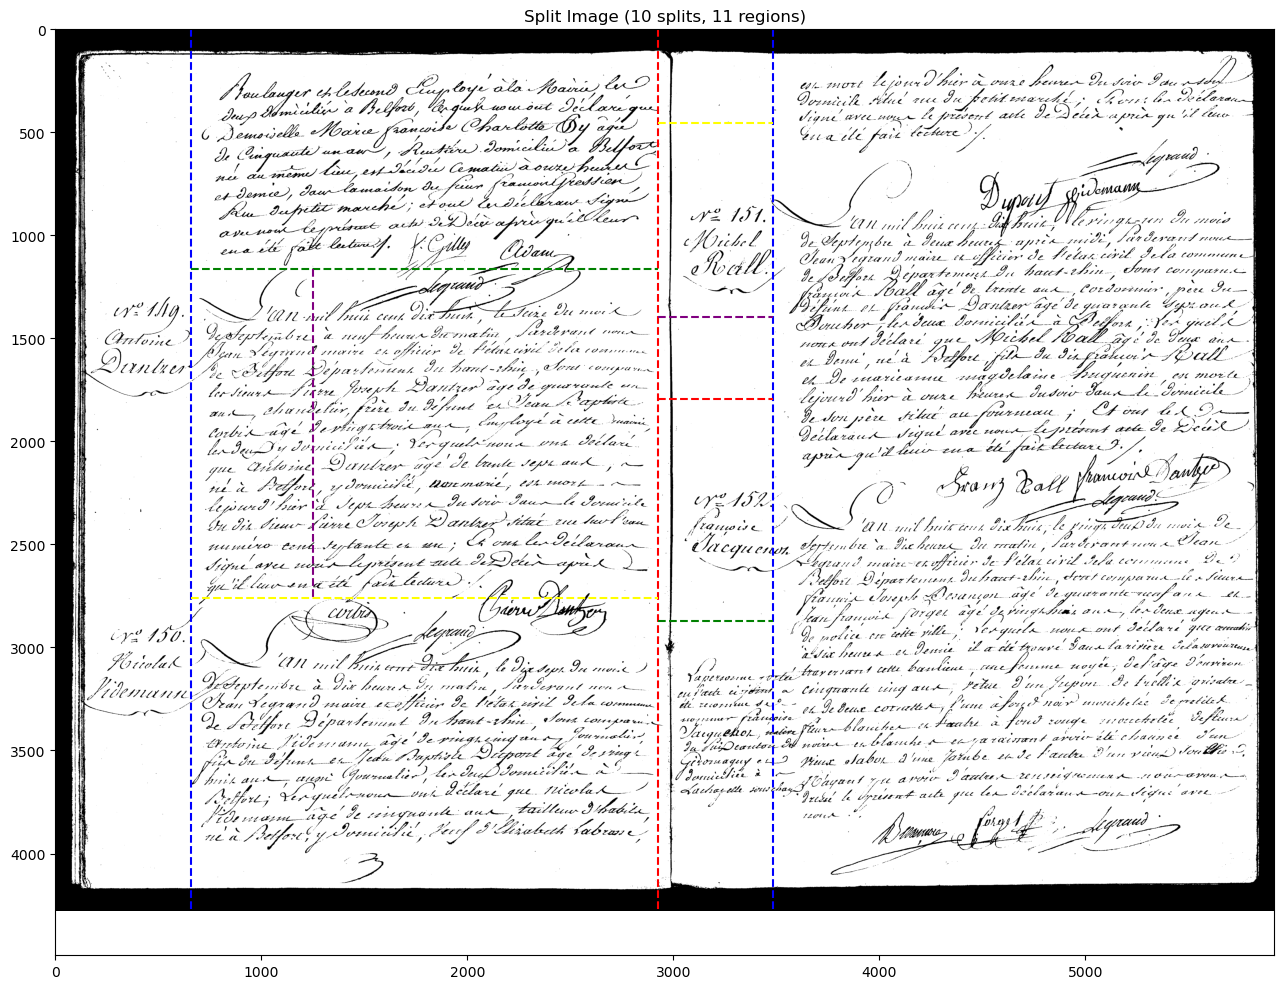

In [49]:
# Create test image
#image = create_test_pattern(height=100, width=150)
#image= gray_image[500:1000, 1000:2150]
# Create splitter instance
splitter = ImageSplitter(binary_image2, max_splits=10, bandwidth=100, margin=400, min_ratio=0)

# Perform splitting
splitter.split()

# Visualize results
splitter.visualize()

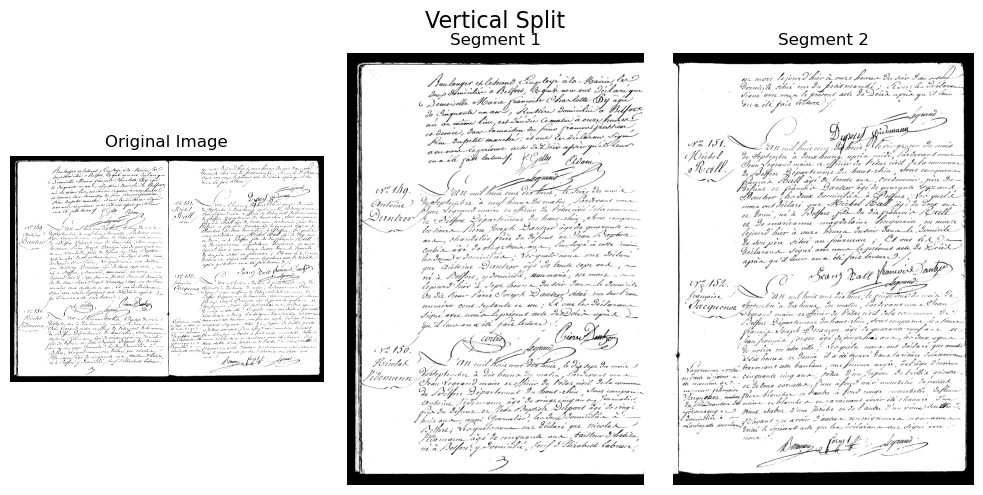

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def evaluate_split(image, axis, bandwidth, margin):
    """
    Evaluate the best split position along a given axis.

    :param image: Binarized image (2D numpy array)
    :param axis: 0 for horizontal split, 1 for vertical split
    :param bandwidth: Bandwidth to consider for splitting (in pixels)
    :param margin: Margin to exclude from the borders (in pixels)
    :return: Best position for the split and the maximum sum of white pixels
    """
    # Sum the white pixels along the specified axis and normalize
    if axis == 0:
        white_pixels = np.sum(image, axis=1) / image.shape[1]  # Normalize by number of columns
    else:
        white_pixels = np.sum(image, axis=0) / image.shape[0]  # Normalize by number of rows

    # Apply margin to exclude borders
    white_pixels[:margin] = 0
    white_pixels[-margin:] = 0

    # Find the position with the maximum sum of white pixels within the bandwidth
    best_position = margin
    max_sum = 0

    for i in range(margin, len(white_pixels) - bandwidth - margin):
        current_sum = np.sum(white_pixels[i:i + bandwidth])
        if current_sum > max_sum:
            max_sum = current_sum
            best_position = i

    return best_position + bandwidth // 2, max_sum

def find_best_split(image, bandwidth=10, margin=20):
    """
    Find the best split (horizontal or vertical) for the image.

    :param image: Binarized image (2D numpy array)
    :param bandwidth: Bandwidth to consider for splitting (in pixels)
    :param margin: Margin to exclude from the borders (in pixels)
    :return: Best split axis (0 for horizontal, 1 for vertical) and the best position
    """
    # Evaluate horizontal and vertical splits
    best_h_pos, max_h_sum = evaluate_split(image, axis=0, bandwidth=bandwidth, margin=margin)
    best_v_pos, max_v_sum = evaluate_split(image, axis=1, bandwidth=bandwidth, margin=margin)

    # Choose the best split (horizontal or vertical)
    if max_h_sum > max_v_sum:
        return 0, best_h_pos  # Horizontal split
    else:
        return 1, best_v_pos  # Vertical split

def segment_image(image, bandwidth=10, margin=20):
    """
    Segment the image at the best position (either horizontal or vertical).

    :param image: Binarized image (2D numpy array)
    :param bandwidth: Bandwidth to consider for splitting (in pixels)
    :param margin: Margin to exclude from the borders (in pixels)
    :return: Two segmented images and the split axis (0 for horizontal, 1 for vertical)
    """
    axis, best_position = find_best_split(image, bandwidth, margin)

    if axis == 0:
        # Horizontal split
        segment1 = image[:best_position, :]
        segment2 = image[best_position:, :]
    else:
        # Vertical split
        segment1 = image[:, :best_position]
        segment2 = image[:, best_position:]

    return segment1, segment2, axis

def plot_segmentation(image, segment1, segment2, axis):
    """
    Plot the original image and the segmented regions.

    :param image: Original binarized image
    :param segment1: First segmented region
    :param segment2: Second segmented region
    :param axis: 0 for horizontal split, 1 for vertical split
    """
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot first segment
    plt.subplot(1, 3, 2)
    plt.imshow(segment1, cmap='gray')
    plt.title('Segment 1')
    plt.axis('off')

    # Plot second segment
    plt.subplot(1, 3, 3)
    plt.imshow(segment2, cmap='gray')
    plt.title('Segment 2')
    plt.axis('off')

    plt.suptitle('Horizontal Split' if axis == 0 else 'Vertical Split', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Segment the image using the best split (horizontal or vertical)
    segment1, segment2, axis = segment_image(binary_image2, bandwidth=50, margin=300)

    # Plot the result of the best segmentation
    plot_segmentation(binary_image2, segment1, segment2, axis)